<a href="https://colab.research.google.com/github/Edison299792458/-/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd           
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time

plt.style.use('ggplot')

In [ ]:
from google.colab import drive                                          
import pandas as pd
drive.mount('/content/gdrive') # 此處需要登入google帳號
# 獲取授權碼之後輸入即可連動雲端硬碟
df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/TWF_Futures_Minute_Trade.txt")
df

Mounted at /content/gdrive


,Date,Time,Open,High,Low,Close,TotalVolume
0,2009/1/5,08:46:00,4722.0,4745.0,4714.0,4727.0,1493
1,2009/1/5,08:47:00,4727.0,4728.0,4711.0,4716.0,608
2,2009/1/5,08:48:00,4713.0,4720.0,4713.0,4716.0,400
3,2009/1/5,08:49:00,4717.0,4722.0,4715.0,4718.0,457
4,2009/1/5,08:50:00,4719.0,4721.0,4718.0,4719.0,233
...,...,...,...,...,...,...,...
1971251,2022/5/23,09:10:00,16210.0,16216.0,16206.0,16214.0,452
1971252,2022/5/23,09:11:00,16215.0,16215.0,16207.0,16210.0,224
1971253,2022/5/23,09:12:00,16210.0,16220.0,16207.0,16218.0,478
1971254,2022/5/23,09:13:00,16218.0,16220.0,16212.0,16218.0,240


In [ ]:
df.index = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df = df.drop(columns=['Date','Time'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['Hour'] = df.index.map(lambda x: x.hour)
df.head(3)

,open,high,low,close,volume,Hour
2009-01-05 08:46:00,4722.0,4745.0,4714.0,4727.0,1493,8
2009-01-05 08:47:00,4727.0,4728.0,4711.0,4716.0,608,8
2009-01-05 08:48:00,4713.0,4720.0,4713.0,4716.0,400,8


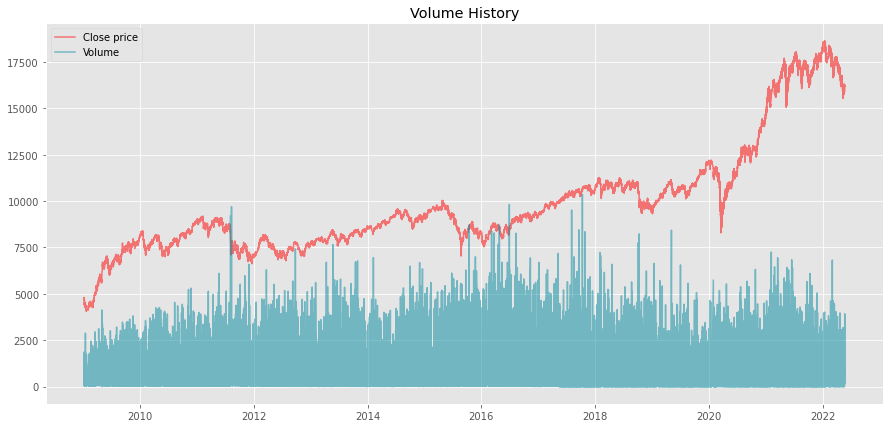

In [ ]:
plt.figure(figsize = (15,7))
plt.plot(df['close'], color = 'red', alpha = 0.5, label = 'Close price')
plt.plot(df['volume'], color = '#01889f', alpha = 0.5, label = 'Volume')
plt.legend(loc='upper left')
plt.title('Volume History');

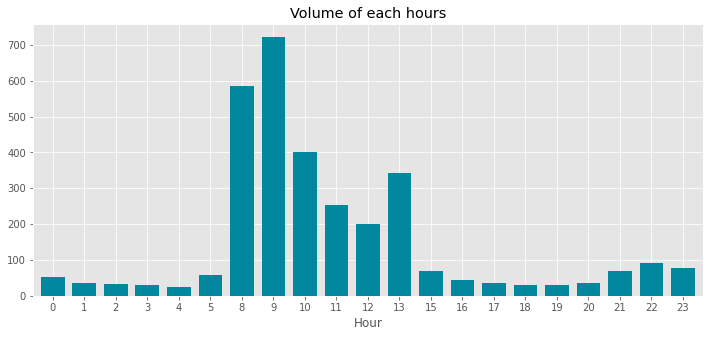

In [ ]:
data = df[(df.index >= '2017-05-15 00:00:00')].copy()
plt.figure(figsize = (12,5))
data.groupby(['Hour'])['volume'].mean().plot(kind='bar', width=0.75, color='#01889f')
plt.xticks(rotation = 0)
plt.title('Volume of each hours');

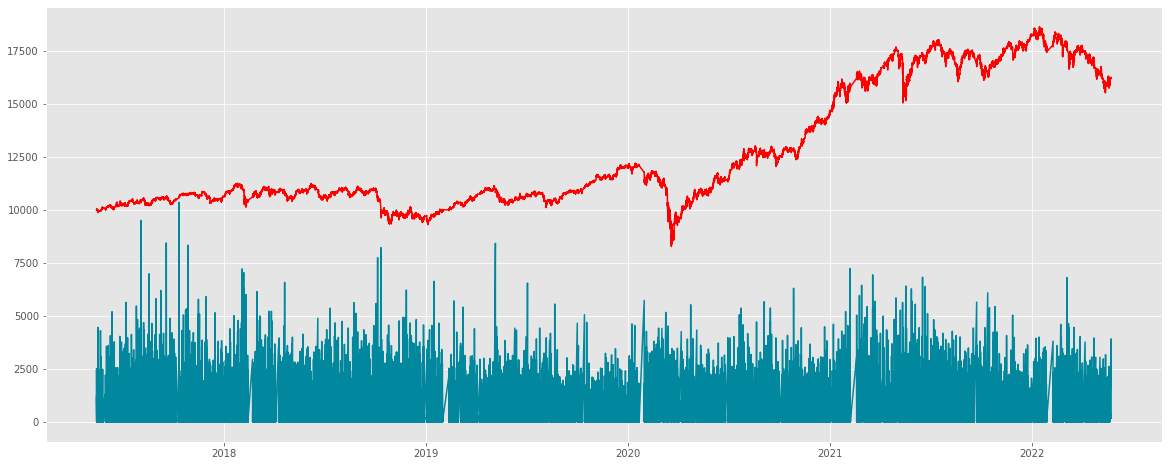

In [ ]:
data
plt.figure(figsize = (20,8))
plt.plot(data['close'], color = 'red', alpha = 1, label = 'Close price')
plt.plot(data['volume'], color = '#01889f', alpha = 1, label = 'Volume')

In [ ]:
rule = '60T'

Morning = df[(df['Hour'] >= 8) & (df['Hour'] <= 13)]
Morning.index = Morning.index + dt.timedelta(minutes=15)

d1 = Morning.resample(rule=rule, closed='right', label='left').first()[['open']]
d2 = Morning.resample(rule=rule, closed='right', label='left').max()[['high']]
d3 = Morning.resample(rule=rule, closed='right', label='left').min()[['low']]
d4 = Morning.resample(rule=rule, closed='right', label='left').last()[['close']]
d5 = Morning.resample(rule=rule, closed='right', label='left').sum()[['volume']]

df_Morning = pd.concat([d1,d2,d3,d4,d5], axis=1)
df_Morning = df_Morning.dropna()
df_Morning.index = df_Morning.index - dt.timedelta(minutes=15)
df_Morning.head()

,open,high,low,close,volume
2009-01-05 08:45:00,4722.0,4797.0,4692.0,4758.0,27508
2009-01-05 09:45:00,4759.0,4767.0,4710.0,4732.0,15701
2009-01-05 10:45:00,4732.0,4733.0,4634.0,4670.0,25172
2009-01-05 11:45:00,4672.0,4688.0,4636.0,4680.0,13241
2009-01-05 12:45:00,4680.0,4698.0,4656.0,4670.0,16247


In [ ]:
df_Morning['Hour'] = df_Morning.index.map(lambda x: x.hour)

In [ ]:
trainData = df_Morning[(df_Morning.index >= '2011-01-01 00:00:00') & (df_Morning.index <= '2019-12-31 00:00:00')].copy()
testData = df_Morning[(df_Morning.index >= '2020-1-1 00:00:00') & (df_Morning.index <= '2022-5-22 00:00:00')].copy()

In [ ]:
fund = 1000000
feePaid = 600
length = 3
NumStd = 1.5
K = 0.04

# trainData['H'] = trainData['high'].shift(1).rolling(window=length, center=False).max()
# trainData['L'] = trainData['low'].shift(1).rolling(window=length, center=False).min()
trainData['MA'] = trainData['close'].rolling(window=3, center=False).mean()
trainData['STD'] = trainData['close'].rolling(window=length, center=False).std()
trainData['upLine'] = trainData['MA'] + NumStd*trainData['STD']
trainData['downLine'] = trainData['MA'] - NumStd*trainData['STD']

trainData.tail(3)

,open,high,low,close,volume,Hour,MA,STD,upLine,downLine
2019-12-30 10:45:00,12096.0,12108.0,12089.0,12104.0,6348,10,12103.666667,6.506407,12113.426277,12093.907056
2019-12-30 11:45:00,12103.0,12110.0,12099.0,12107.0,3898,11,12102.666667,5.131601,12110.364069,12094.969265
2019-12-30 12:45:00,12108.0,12109.0,12065.0,12069.0,17832,12,12093.333333,21.126603,12125.023237,12061.643430


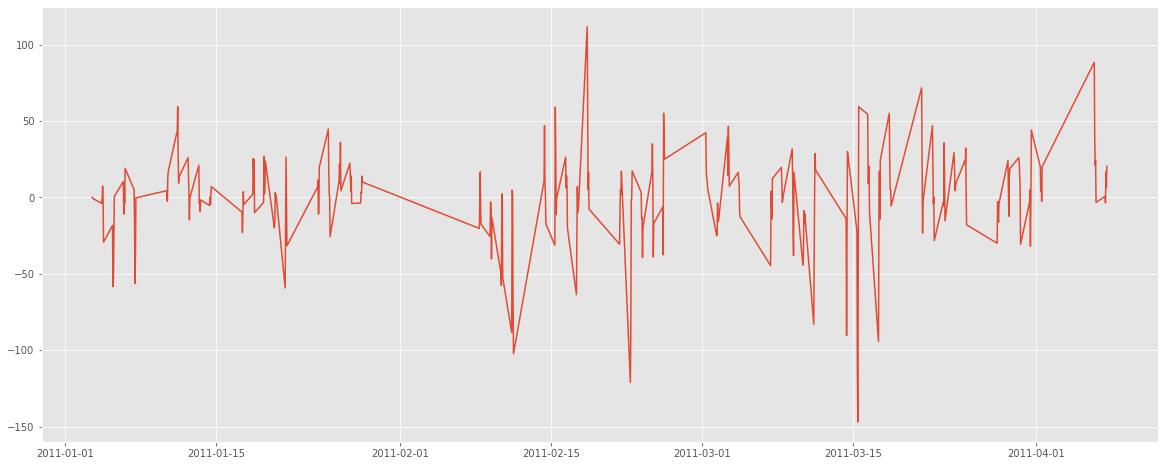

<Figure size 432x288 with 0 Axes>

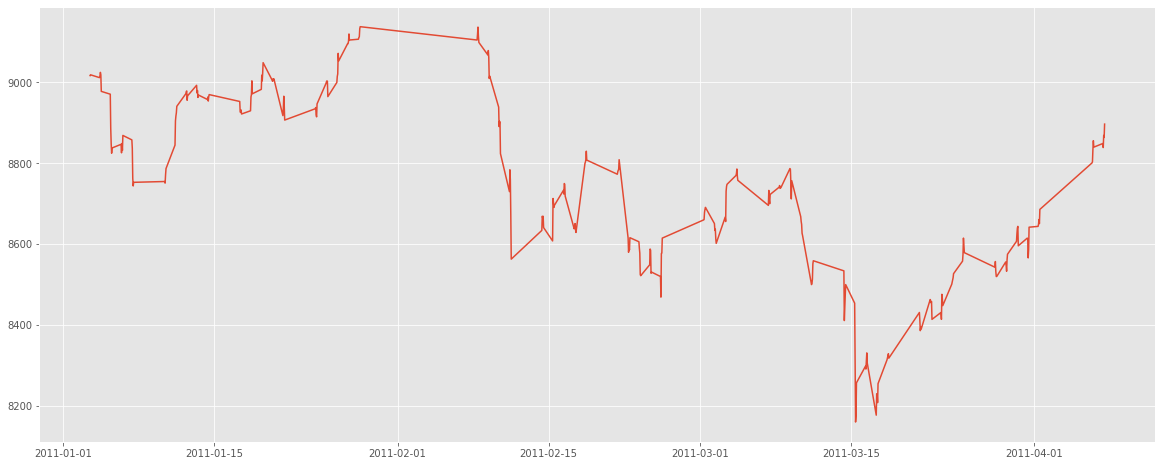

In [ ]:
trainData['nor']= trainData['close']-trainData['MA']
plt.figure(figsize = (20,8))
plt.plot(trainData['nor'][3:300])
plt.figure()
plt.figure(figsize = (20,8))
plt.plot(trainData['close'][3:300])
plt.show()


In [ ]:
trainData

,open,high,low,close,volume,Hour,MA,STD,upLine,downLine,nor
2011-01-03 08:45:00,9000.0,9029.0,8995.0,9005.0,20508,8,NaN,NaN,NaN,NaN,NaN
2011-01-03 09:45:00,9005.0,9014.0,8997.0,9011.0,9022,9,NaN,NaN,NaN,NaN,NaN
2011-01-03 10:45:00,9010.0,9030.0,9010.0,9023.0,12537,10,9013.000000,9.165151,9026.747727,8999.252273,10.000000
2011-01-03 11:45:00,9024.0,9026.0,9014.0,9017.0,7529,11,9017.000000,6.000000,9026.000000,9008.000000,0.000000
2011-01-03 12:45:00,9016.0,9024.0,9009.0,9019.0,11769,12,9019.666667,3.055050,9024.249242,9015.084091,-0.666667
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 08:45:00,12091.0,12125.0,12080.0,12110.0,24685,8,12101.000000,7.810250,12112.715375,12089.284625,9.000000
2019-12-30 09:45:00,12110.0,12112.0,12076.0,12097.0,13297,9,12101.333333,7.505553,12112.591664,12090.075003,-4.333333
2019-12-30 10:45:00,12096.0,12108.0,12089.0,12104.0,6348,10,12103.666667,6.506407,12113.426277,12093.907056,0.333333
2019-12-30 11:45:00,12103.0,12110.0,12099.0,12107.0,3898,11,12102.666667,5.131601,12110.364069,12094.969265,4.333333


<Figure size 432x288 with 0 Axes>

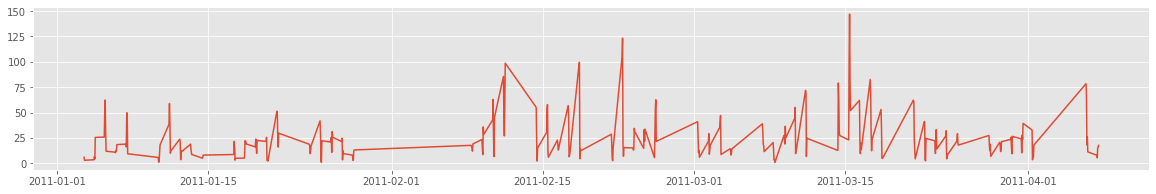

<Figure size 432x288 with 0 Axes>

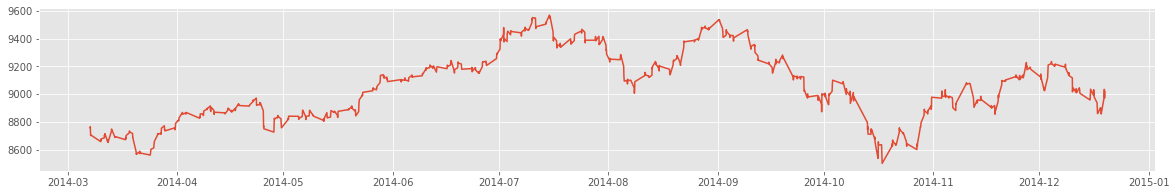

<Figure size 432x288 with 0 Axes>

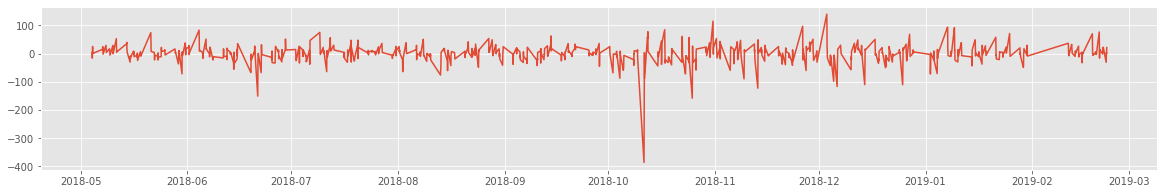

In [ ]:
plt.figure()
plt.figure(figsize = (20,3))
plt.plot(trainData['STD'][3:300])
plt.show()
plt.figure()
plt.figure(figsize = (20,3))
plt.plot(trainData['close'][3900:4900])
plt.show()
plt.figure()
plt.figure(figsize = (20,3))
plt.plot(trainData['nor'][9000:10000])
plt.show()

In [ ]:
settlementDate_= pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/結算日/settlementDate.txt")


settlementDate_.columns = ['settlementDate', 'futures', 'settlementPrice']
settlementDate_

,settlementDate,futures,settlementPrice
0,2022/08/03,202208W1,14707
1,2022/07/27,202207W4,14887
2,2022/07/20,202207,14713
3,2022/07/13,202207W2,14384
4,2022/07/06,202207W1,14015
...,...,...,...
508,2009/12/16,200912,7752
509,2009/11/18,200911,7786
510,2009/10/21,200910,7705
511,2009/09/16,200909,7445


In [ ]:
bool_ = [False if 'W' in i else True for i in settlementDate_['futures']]
bool_

[False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False

In [ ]:
settlementDate = [i.replace('/','-') for i in list(settlementDate_[bool_]['settlementDate'])]

In [ ]:
df_arr = np.array(trainData)
time_arr = np.array(trainData.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]
BS = None


In [ ]:
trainData

,open,high,low,close,volume,Hour,MA,STD,upLine,downLine,nor
2011-01-03 08:45:00,9000.0,9029.0,8995.0,9005.0,20508,8,NaN,NaN,NaN,NaN,NaN
2011-01-03 09:45:00,9005.0,9014.0,8997.0,9011.0,9022,9,NaN,NaN,NaN,NaN,NaN
2011-01-03 10:45:00,9010.0,9030.0,9010.0,9023.0,12537,10,9013.000000,9.165151,9026.747727,8999.252273,10.000000
2011-01-03 11:45:00,9024.0,9026.0,9014.0,9017.0,7529,11,9017.000000,6.000000,9026.000000,9008.000000,0.000000
2011-01-03 12:45:00,9016.0,9024.0,9009.0,9019.0,11769,12,9019.666667,3.055050,9024.249242,9015.084091,-0.666667
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 08:45:00,12091.0,12125.0,12080.0,12110.0,24685,8,12101.000000,7.810250,12112.715375,12089.284625,9.000000
2019-12-30 09:45:00,12110.0,12112.0,12076.0,12097.0,13297,9,12101.333333,7.505553,12112.591664,12090.075003,-4.333333
2019-12-30 10:45:00,12096.0,12108.0,12089.0,12104.0,6348,10,12103.666667,6.506407,12113.426277,12093.907056,0.333333
2019-12-30 11:45:00,12103.0,12110.0,12099.0,12107.0,3898,11,12102.666667,5.131601,12110.364069,12094.969265,4.333333


In [ ]:
len(df_arr)
#對跌不敏感的多頭策略+對漲不敏感的空頭策略

11050

                       profit  profitfee
2011-01-03 08:45:00       0.0        0.0
2011-01-03 09:45:00       0.0        0.0
2011-01-03 10:45:00       0.0        0.0
2011-01-03 11:45:00       0.0        0.0
2011-01-03 12:45:00       0.0        0.0
...                       ...        ...
2019-12-30 08:45:00  771600.0   698400.0
2019-12-30 09:45:00  771600.0   698400.0
2019-12-30 10:45:00  771600.0   698400.0
2019-12-30 11:45:00  771600.0   698400.0
2019-12-30 12:45:00  771600.0   698400.0

[11050 rows x 2 columns]


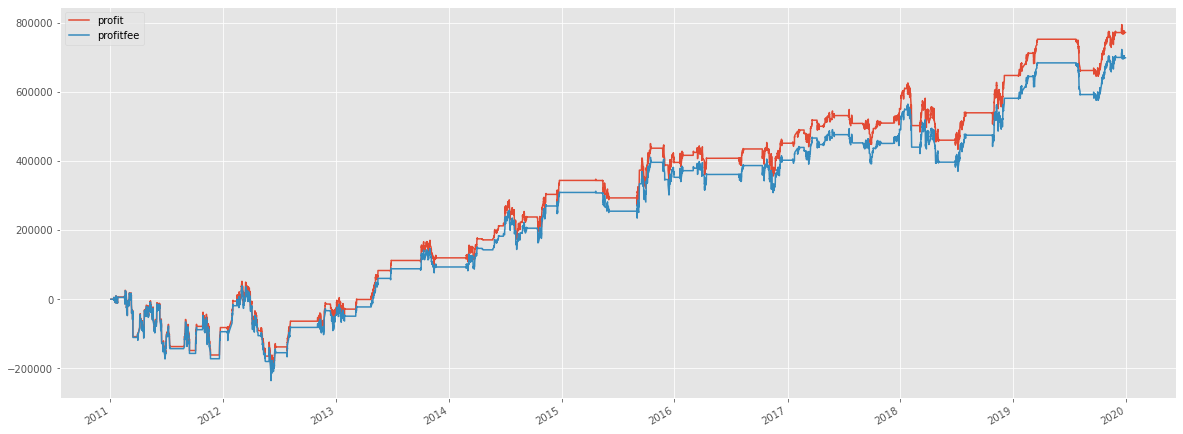

<Figure size 432x288 with 0 Axes>

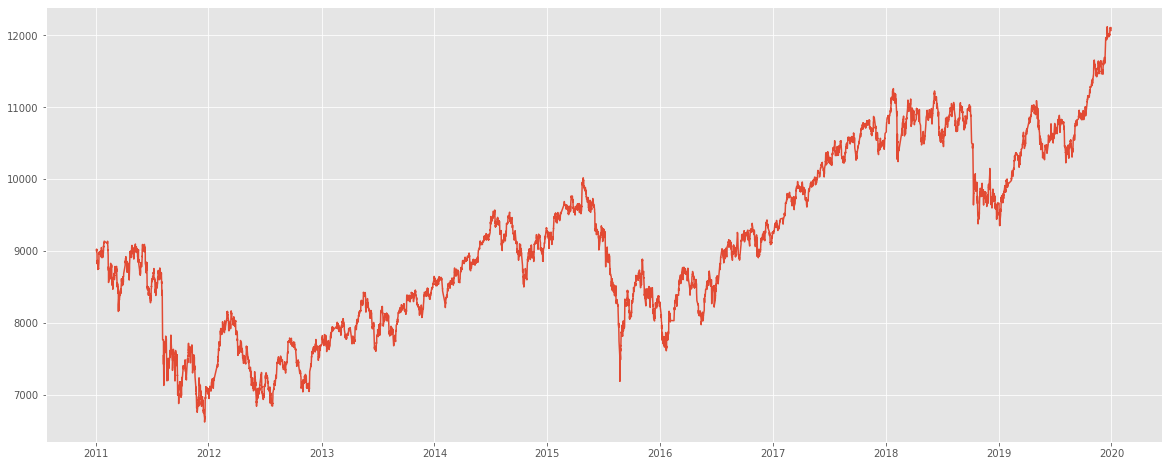

In [ ]:
for n in range(0,1):
  BS = None
  buy = []
  sell = []
  sellshort = []
  buytocover = []
  profit_list = [0]
  profit_fee_list = [0]
  profit_fee_list_realized = []
  ccsellshort=[]
  eexitBuyToCover=[]
  K=0.05
  entrySellShort=None
  for i in range(len(df_arr)):

      if i == len(df_arr)-1:
          break
          
      ## 進場邏輯
      ccsellshort.append(entrySellShort)
      entryLong = df_arr[i,10] >25 and df_arr[i,7]< 25


      #or (df_arr[i,10] >  -100 and df_arr[i,10] <=  -50) 
      #df_arr[i,10] < -120000
      #if df_arr[i,10] <  -120 or entrySellShort ==True:
      #  entrySellShort =True


      #entrySellShort =  df_arr[i,10] <  -70  and df_arr[i,7] >50
      entryCondition = date_arr[i] not in settlementDate
      
      ## 出場邏輯
      if(df_arr[i,10] ==0):
        exitShort = True
      else:
        exitShort = False

      if(df_arr[i,10] ==0):
        exitBuyToCover=True
      else:
        exitBuyToCover=False
      exitCondition = date_arr[i] in settlementDate 
    

      ## 停利停損邏輯
      if BS == 'B':
          stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-K)
          stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
      elif BS == 'S':
          stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+K)
          stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)

  #     if exitCondition == True:
  #         print(f'{time_arr[i]}')

      if BS == None:
          profit_list.append(0)
          profit_fee_list.append(0)
          
          if entryLong and entryCondition:
              BS = 'B'
              t = i+1
              buy.append(t)

          elif entrySellShort and entryCondition:
              BS = 'S'
              t = i+1
              sellshort.append(t)
      
      elif BS == 'B':
          profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
          profit_list.append(profit)
              
          if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
              pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])
              profit_fee = profit - feePaid*2
              profit_fee_list.append(profit_fee)
              sell.append(i+1)
              BS=None
              
              # Realized PnL
              profit_fee_realized = pl_round - feePaid*2
              profit_fee_list_realized.append(profit_fee_realized)
              
          else:
              profit_fee = profit
              profit_fee_list.append(profit_fee)
              
      elif BS == 'S': 
          profit = 200 * (df_arr[i,0] - df_arr[i+1,0])
          profit_list.append(profit)
          
          if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
              pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])
              profit_fee = profit - feePaid*2
              profit_fee_list.append(profit_fee)
              buytocover.append(i+1)
              BS=None
              

              # Realized PnL
              profit_fee_realized = pl_round - feePaid*2
              profit_fee_list_realized.append(profit_fee_realized)

          else:
              profit_fee = profit
              profit_fee_list.append(profit_fee)
        
              
  equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
  print(equity)
  equity.plot(grid=True, figsize=(20,8));

  plt.figure()
  plt.figure(figsize = (20,8))
  plt.plot(trainData['close'])
  plt.show()

                       profit  profitfee
2011-01-03 08:45:00       0.0        0.0
2011-01-03 09:45:00       0.0        0.0
2011-01-03 10:45:00       0.0        0.0
2011-01-03 11:45:00       0.0        0.0
2011-01-03 12:45:00       0.0        0.0
...                       ...        ...
2019-12-30 08:45:00  206200.0   195400.0
2019-12-30 09:45:00  206200.0   195400.0
2019-12-30 10:45:00  206200.0   195400.0
2019-12-30 11:45:00  206200.0   195400.0
2019-12-30 12:45:00  206200.0   195400.0

[11050 rows x 2 columns]


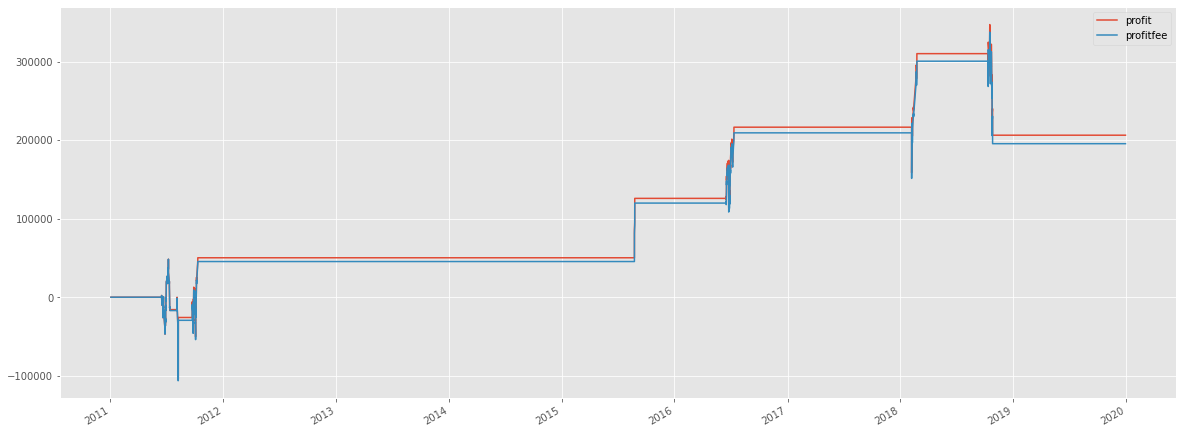

<Figure size 432x288 with 0 Axes>

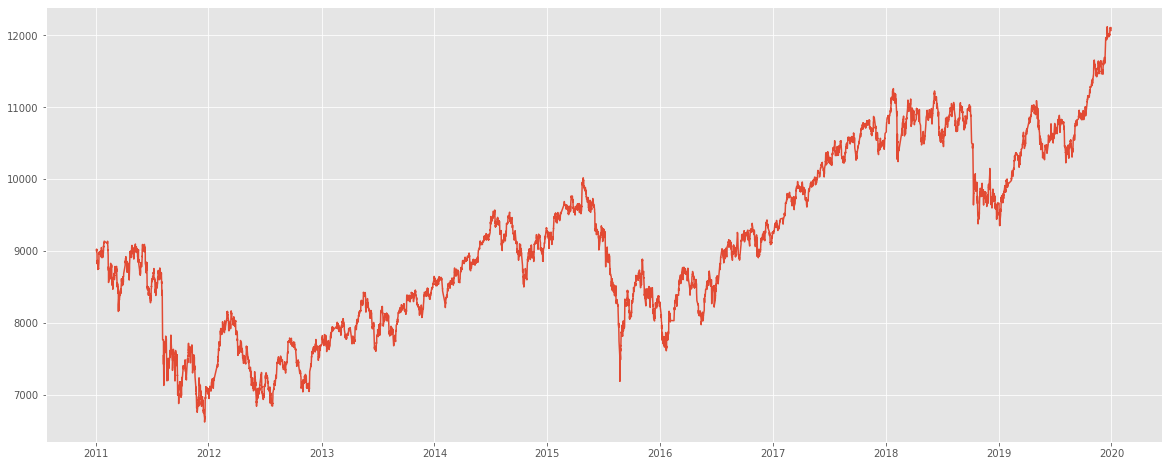

In [ ]:
#隊漲不敏感的空頭策略
for b in range(1,2):

  BS = None
  buy = []
  sell = []
  sellshort = []
  buytocover = []
  Bprofit_list = [0]
  Bprofit_fee_list = [0]
  Bprofit_fee_list_realized = []
  ccsellshort=[]
  eexitBuyToCover=[]
  K=0.05
  entrySellShort=None
  for i in range(len(df_arr)):

      if i == len(df_arr)-1:
          break
          
      ## 進場邏輯
      #ccsellshort.append(entrySellShort)
      entryLong = df_arr[i,10] <  -70 and df_arr[i,7]>150


      #or (df_arr[i,10] >  -100 and df_arr[i,10] <=  -50) 
      #df_arr[i,10] < -120000
      #if df_arr[i,10] <  -120 or entrySellShort ==True:
      #  entrySellShort =True


      #entrySellShort =  df_arr[i,10] <  -70 and df_arr[i,7]>25
      entryCondition = date_arr[i] not in settlementDate
      
      ## 出場邏輯
      if(df_arr[i,10] ==0):
        exitShort = True
      else:
        exitShort = False

      if(df_arr[i,10] ==0):
        exitBuyToCover=True
      else:
        exitBuyToCover=False
      exitCondition = date_arr[i] in settlementDate 
    

      ## 停利停損邏輯
      if BS == 'B':
          stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-K)
          stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
      elif BS == 'S':
          stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+K)
          stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)

  #     if exitCondition == True:
  #         print(f'{time_arr[i]}')

      if BS == None:
          Bprofit_list.append(0)
          Bprofit_fee_list.append(0)
          
          if entryLong and entryCondition:
              BS = 'B'
              t = i+1
              buy.append(t)

          elif entrySellShort and entryCondition:
              BS = 'S'
              t = i+1
              sellshort.append(t)
      
      elif BS == 'B':
          Bprofit = 200 * (df_arr[i+1,0] - df_arr[i,0])
          Bprofit_list.append(Bprofit)
              
          if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
              pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])
              Bprofit_fee = Bprofit - feePaid*2
              Bprofit_fee_list.append(Bprofit_fee)
              sell.append(i+1)
              BS=None
              
              # Realized PnL
              Bprofit_fee_realized = pl_round - feePaid*2
              Bprofit_fee_list_realized.append(Bprofit_fee_realized)
              
          else:
              Bprofit_fee = Bprofit
              Bprofit_fee_list.append(Bprofit_fee)
              
      elif BS == 'S': 
          Bprofit = 200 * (df_arr[i,0] - df_arr[i+1,0])
          Bprofit_list.append(Bprofit)
          
          if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
              pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])
              Bprofit_fee = Bprofit - feePaid*2
              Bprofit_fee_list.append(Bprofit_fee)
              buytocover.append(i+1)
              BS=None
              

              # Realized PnL
              Bprofit_fee_realized = pl_round - feePaid*2
              Bprofit_fee_list_realized.append(Bprofit_fee_realized)

          else:
              Bprofit_fee = Bprofit
              Bprofit_fee_list.append(Bprofit_fee)
        
              
  equity = pd.DataFrame({'profit':np.cumsum(Bprofit_list), 'profitfee':np.cumsum(Bprofit_fee_list)}, index=trainData.index)
  print(equity)
  equity.plot(grid=True, figsize=(20,8));

  plt.figure()
  plt.figure(figsize = (20,8))
  plt.plot(trainData['close'])
  plt.show()

In [ ]:
BBS=np.cumsum(profit_fee_list)
SSS=np.cumsum(Bprofit_fee_list)
ttt=BBS+SSS


<Figure size 432x288 with 0 Axes>

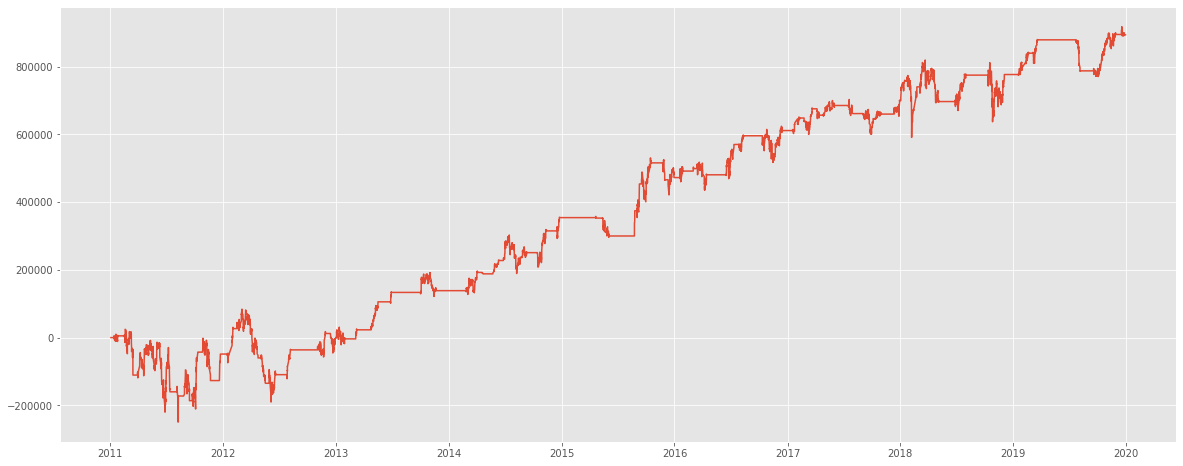

In [ ]:
plt.figure()
plt.figure(figsize = (20,8))
plt.plot(trainData.index,ttt)
plt.show()

In [ ]:
print(sellshort)
print(buy)
print(sell)
print(buytocover)
print(len(sellshort)+len(buytocover))
print(ccsellshort)

print(eexitBuyToCover)

[]
[536, 716, 726, 886, 5712, 6702, 8736, 8751, 9556]
[631, 724, 729, 941, 5718, 6776, 8749, 8772, 9613]
[]
0
[]
[]


In [ ]:
fund = 1000000
feePaid = 600
length = 3
NumStd = 1.5
K = 0.04

# trainData['H'] = trainData['high'].shift(1).rolling(window=length, center=False).max()
# trainData['L'] = trainData['low'].shift(1).rolling(window=length, center=False).min()
testData ['MA'] = testData ['close'].rolling(window=3, center=False).mean()
testData ['STD'] = testData ['close'].rolling(window=length, center=False).std()
testData ['upLine'] = testData ['MA'] + NumStd*testData ['STD']
testData ['downLine'] = testData ['MA'] - NumStd*testData ['STD']

testData .tail(3)

,open,high,low,close,volume,Hour,MA,STD,upLine,downLine
2022-05-20 10:45:00,16104.0,16140.0,16104.0,16134.0,12993,10,16110.333333,21.501938,16142.586240,16078.080426
2022-05-20 11:45:00,16134.0,16140.0,16113.0,16128.0,7654,11,16122.333333,15.307950,16145.295258,16099.371408
2022-05-20 12:45:00,16129.0,16145.0,16110.0,16135.0,12758,12,16132.333333,3.785939,16138.012242,16126.654425


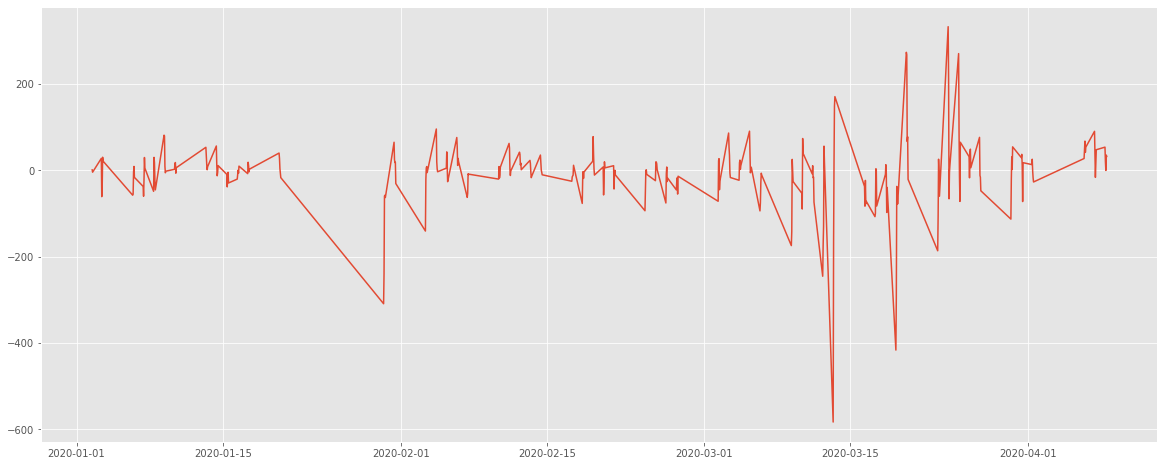

<Figure size 432x288 with 0 Axes>

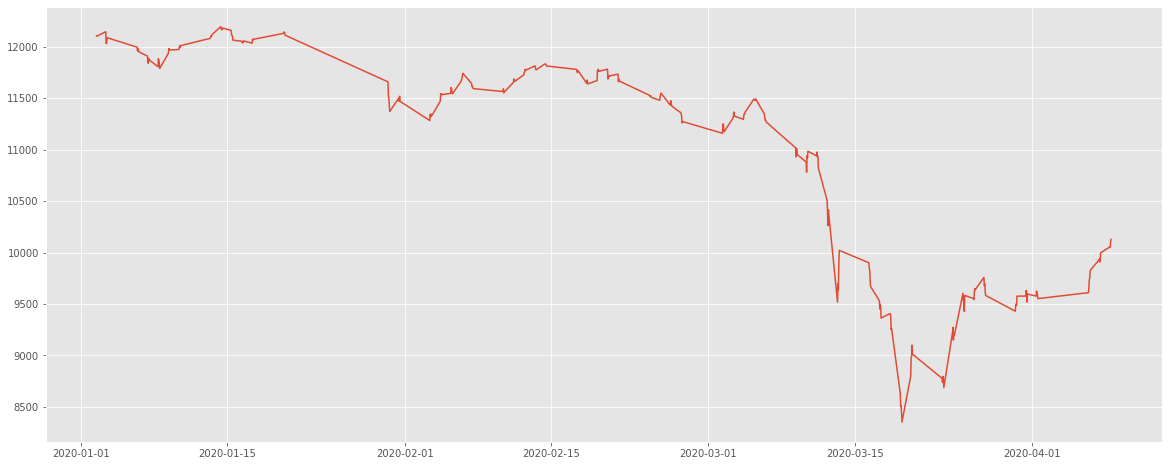

In [ ]:
testData['nor']= testData['close']-testData['MA']
plt.figure(figsize = (20,8))
plt.plot(testData['nor'][3:300])
plt.figure()
plt.figure(figsize = (20,8))
plt.plot(testData['close'][3:300])
plt.show()

In [ ]:
testData

,open,high,low,close,volume,Hour,MA,STD,upLine,downLine,nor
2020-01-02 08:45:00,12044.0,12073.0,12023.0,12047.0,40864,8,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:45:00,12047.0,12104.0,12046.0,12095.0,27791,9,NaN,NaN,NaN,NaN,NaN
2020-01-02 10:45:00,12095.0,12115.0,12089.0,12112.0,10996,10,12084.666667,33.709544,12135.230982,12034.102351,27.333333
2020-01-02 11:45:00,12112.0,12120.0,12105.0,12105.0,5746,11,12104.000000,8.544004,12116.816006,12091.183994,1.000000
2020-01-02 12:45:00,12105.0,12113.0,12096.0,12102.0,15002,12,12106.333333,5.131601,12114.030735,12098.635931,-4.333333
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20 08:45:00,16069.0,16110.0,16013.0,16092.0,32305,8,15974.666667,101.736588,16127.271549,15822.061785,117.333333
2022-05-20 09:45:00,16091.0,16124.0,16062.0,16105.0,19768,9,16036.000000,108.448144,16198.672216,15873.327784,69.000000
2022-05-20 10:45:00,16104.0,16140.0,16104.0,16134.0,12993,10,16110.333333,21.501938,16142.586240,16078.080426,23.666667
2022-05-20 11:45:00,16134.0,16140.0,16113.0,16128.0,7654,11,16122.333333,15.307950,16145.295258,16099.371408,5.666667


In [ ]:
tdf_arr = np.array(testData)
ttime_arr = np.array(testData.index)
tdate_arr = [pd.to_datetime(i).date() for i in ttime_arr]
BS = None


<Figure size 432x288 with 0 Axes>

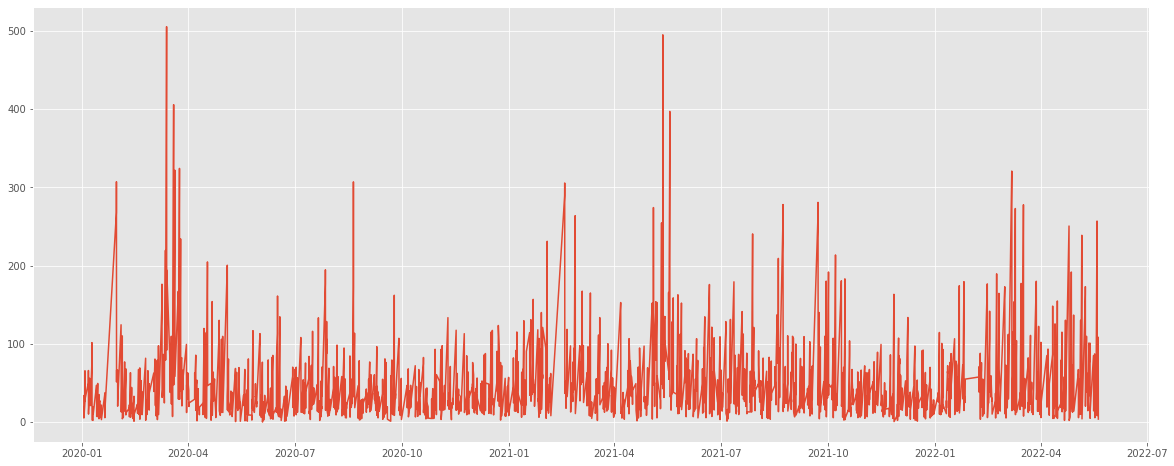

In [ ]:
plt.figure()
plt.figure(figsize = (20,8))
plt.plot(testData['STD'])
plt.show()


In [ ]:
#多頭策略
BS = None
buy = []
sell = []
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []
ccsellshort=[]
eexitBuyToCover=[]
K=0.05
entrySellShort=None
for i in range(len(tdf_arr)):

    if i == len(tdf_arr)-1:
        break
        
    ## 進場邏輯
    ccsellshort.append(entrySellShort)
    entryLong =  tdf_arr[i,10] > 25  and tdf_arr[i,7] < 200


    #tdf_arr[i,10] < -120000
    #if tdf_arr[i,10] <  -120 or entrySellShort ==True:
    #  entrySellShort =True
    #entrySellShort = df_arr[i,10] < -120 
    #or (tdf_arr[i,10] < -55 and df_arr[i,10] >  -100)
    entryCondition = tdate_arr[i] not in settlementDate
    
    ## 出場邏輯
    if(tdf_arr[i,10] ==0):
      exitShort = True
    else:
      exitShort = False

    if(tdf_arr[i,10] ==0):
      exitBuyToCover=True
    else:
      exitBuyToCover=False
    exitCondition = date_arr[i] in settlementDate 
   

    ## 停利停損邏輯
    if BS == 'B':
        stopLoss = tdf_arr[i,3] <= tdf_arr[t,0] * (1-K)
        stopProfit = tdf_arr[i,3] >= tdf_arr[t,0] * (1+K)
    elif BS == 'S':
        stopLoss = tdf_arr[i,3] >= tdf_arr[t,0] * (1+K)
        stopProfit = tdf_arr[i,3] <= tdf_arr[t,0] * (1-K)

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        
        if entryLong and entryCondition:
            BS = 'B'
            t = i+1
            buy.append(t)

        elif entrySellShort and entryCondition:
            BS = 'S'
            t = i+1
            sellshort.append(t)
    
    elif BS == 'B':
        profit = 200 * (tdf_arr[i+1,0] - tdf_arr[i,0])
        profit_list.append(profit)
            
        if exitShort or i == len(tdf_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (tdf_arr[i+1,0] - tdf_arr[t,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
            
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
    elif BS == 'S': 
        profit = 200 * (tdf_arr[i,0] - tdf_arr[i+1,0])
        profit_list.append(profit)
        
        if exitBuyToCover or i == len(tdf_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (tdf_arr[t,0] - tdf_arr[i+1,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None
            

            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
       
            
equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=testData.index)
print(equity)
equity.plot(grid=True, figsize=(20,8));

plt.figure()
plt.figure(figsize = (20,8))
plt.plot(testData['close'])
plt.show()

NameError: ignored

In [ ]:
print(len(buy))
print(40*1200)

40
48000


                       profit  profitfee
2020-01-02 08:45:00       0.0        0.0
2020-01-02 09:45:00       0.0        0.0
2020-01-02 10:45:00       0.0        0.0
2020-01-02 11:45:00       0.0        0.0
2020-01-02 12:45:00       0.0        0.0
...                       ...        ...
2022-05-20 08:45:00  425800.0   418600.0
2022-05-20 09:45:00  425800.0   418600.0
2022-05-20 10:45:00  425800.0   418600.0
2022-05-20 11:45:00  425800.0   418600.0
2022-05-20 12:45:00  425800.0   418600.0

[2890 rows x 2 columns]


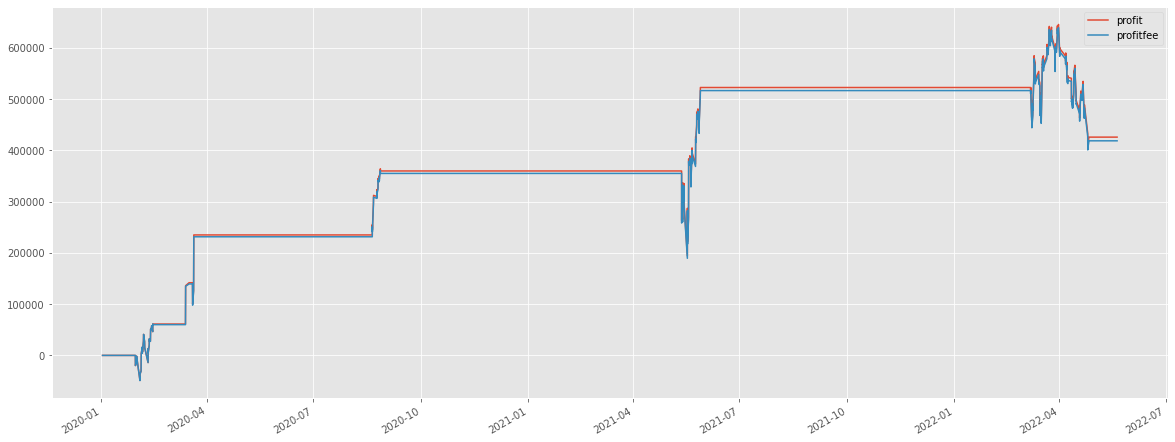

<Figure size 432x288 with 0 Axes>

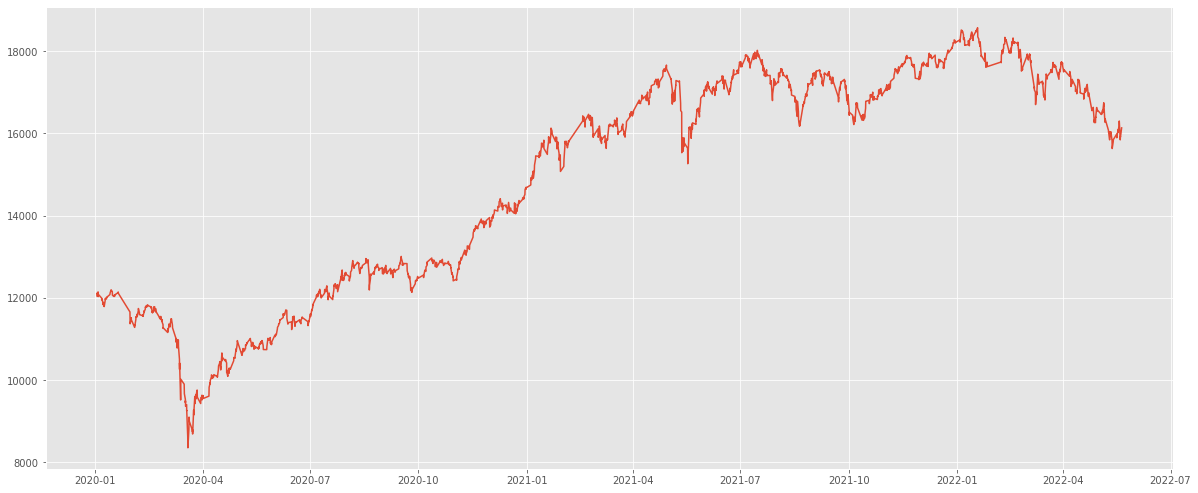

In [ ]:

#空頭保護策略
BS = None
bbuy = []
ssell = []
ssellshort = []
bbuytocover = []
vprofit_list = [0]
vprofit_fee_list = [0]
vprofit_fee_list_realized = []
ccsellshort=[]
eexitBuyToCover=[]
K=0.05
entrySellShort=None
for i in range(len(tdf_arr)):

    if i == len(tdf_arr)-1:
        break
        
    ## 進場邏輯
    ccsellshort.append(entrySellShort)
    entryLong =  tdf_arr[i,10] < -70 and   tdf_arr[i,7] > 300
    
    #entrySellShort = tdf_arr[i,10] < -70 and   tdf_arr[i,7] > 300
    
    entryCondition = tdate_arr[i] not in settlementDate
    
    ## 出場邏輯
    if(tdf_arr[i,10] ==0 and tdf_arr[i,7]<100):
      exitShort = True
    else:
      exitShort = False

    if(tdf_arr[i,10] ==0):
      exitBuyToCover=True
    else:
      exitBuyToCover=False
    exitCondition = date_arr[i] in settlementDate 
   

    ## 停利停損邏輯
    if BS == 'B':
        stopLoss = tdf_arr[i,3] <= tdf_arr[t,0] * (1-K)
        stopProfit = tdf_arr[i,3] >= tdf_arr[t,0] * (1+K)
    elif BS == 'S':
        stopLoss = tdf_arr[i,3] >= tdf_arr[t,0] * (1+K)
        stopProfit = tdf_arr[i,3] <= tdf_arr[t,0] * (1-K)

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if BS == None:
        vprofit_list.append(0)
        vprofit_fee_list.append(0)
        
        if entryLong and entryCondition:
            BS = 'B'
            t = i+1
            bbuy.append(t)

        elif entrySellShort and entryCondition:
            BS = 'S'
            t = i+1
            ssellshort.append(t)
    
    elif BS == 'B':
        vprofit = 200 * (tdf_arr[i+1,0] - tdf_arr[i,0])
        vprofit_list.append(vprofit)
            
        if exitShort or i == len(tdf_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (tdf_arr[i+1,0] - tdf_arr[t,0])
            vprofit_fee = vprofit - feePaid*2
            vprofit_fee_list.append(vprofit_fee)
            ssell.append(i+1)
            BS=None
            
            # Realized PnL
            vprofit_fee_realized = pl_round - feePaid*2
            vprofit_fee_list_realized.append(vprofit_fee_realized)
            
        else:
            vprofit_fee = vprofit
            vprofit_fee_list.append(vprofit_fee)
            
    elif BS == 'S': 
        vprofit = 200 * (tdf_arr[i,0] - tdf_arr[i+1,0])
        vprofit_list.append(vprofit)
        
        if exitBuyToCover or i == len(tdf_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (tdf_arr[t,0] - tdf_arr[i+1,0])
            vprofit_fee = vprofit - feePaid*2
            vprofit_fee_list.append(vprofit_fee)
            bbuytocover.append(i+1)
            BS=None
            

            # Realized PnL
            vprofit_fee_realized = pl_round - feePaid*2
            vprofit_fee_list_realized.append(vprofit_fee_realized)

        else:
            vprofit_fee = vprofit
            vprofit_fee_list.append(vprofit_fee)
       
            
vequity = pd.DataFrame({'profit':np.cumsum(vprofit_list), 'profitfee':np.cumsum(vprofit_fee_list)}, index=testData.index)
print(vequity)
vequity.plot(grid=True, figsize=(20,8));

plt.figure()
plt.figure(figsize = (20.2,8.5))
plt.plot(testData['close'])
plt.show()

In [ ]:
print(bbuy)
print(ssell)
print(ssellshort)
print(bbuytocover)
print(len(sellshort)+len(buytocover))
print(ccsellshort)

print(eexitBuyToCover)

[67, 216, 236, 762, 1632, 2631]
[123, 220, 244, 786, 1692, 2800]
[]
[]
0
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, No

<Figure size 432x288 with 0 Axes>

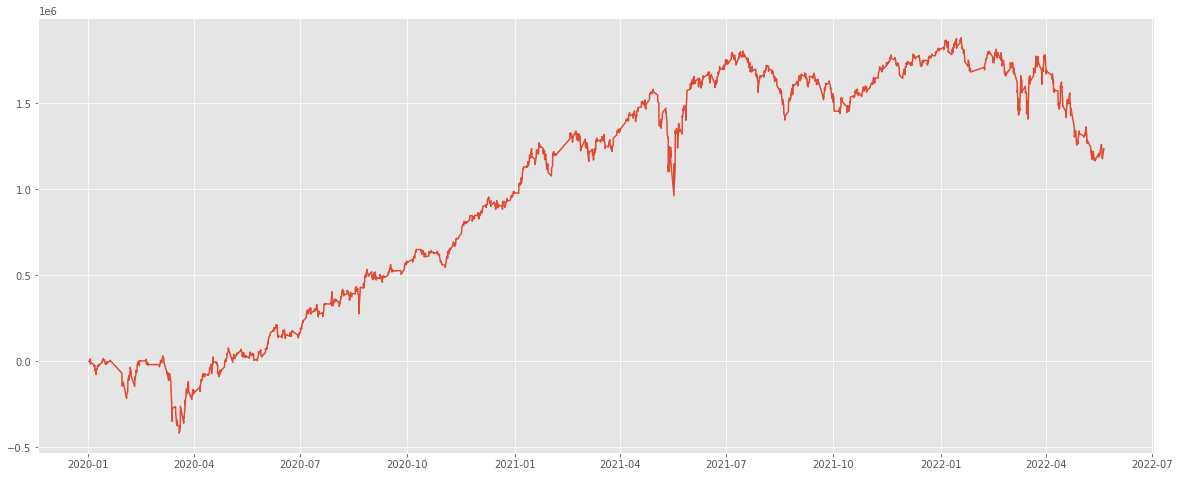

<Figure size 432x288 with 0 Axes>

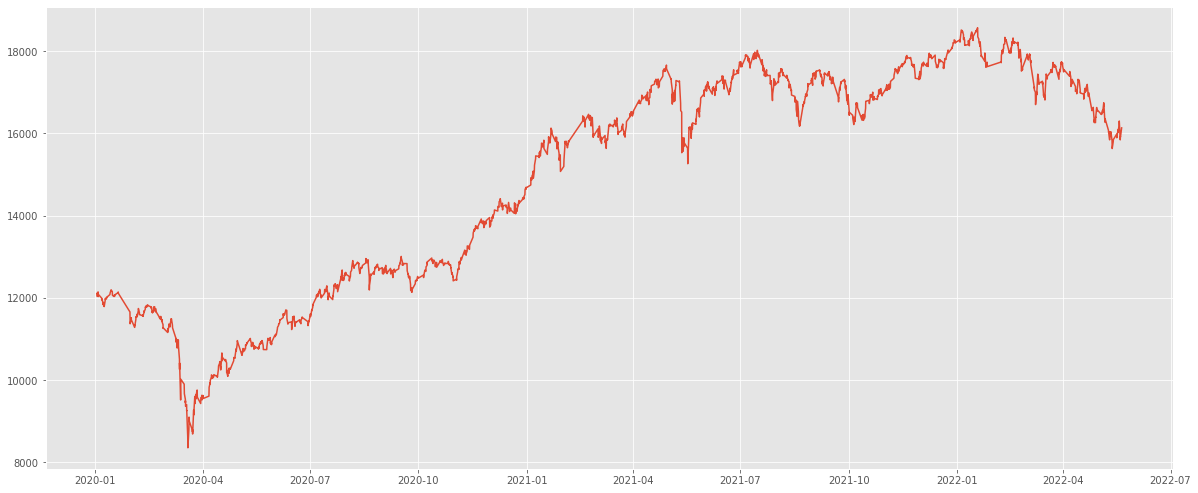

In [ ]:
bst=np.cumsum(profit_fee_list)
sst=np.cumsum(vprofit_fee_list)
tt=bst+sst
plt.figure()
plt.figure(figsize = (20,8))
plt.plot(testData.index,tt)
plt.show()
plt.figure()
plt.figure(figsize = (20.2,8.5))
plt.plot(testData['close'])
plt.show()

In [ ]:
nequity=equity+vequity
nequity

,profit,profitfee
2020-01-02 08:45:00,0.0,0.0
2020-01-02 09:45:00,0.0,0.0
2020-01-02 10:45:00,0.0,0.0
2020-01-02 11:45:00,0.0,0.0
2020-01-02 12:45:00,-1400.0,-1400.0
...,...,...
2022-05-20 08:45:00,1277000.0,1223000.0
2022-05-20 09:45:00,1281400.0,1227400.0
2022-05-20 10:45:00,1284000.0,1230000.0
2022-05-20 11:45:00,1290000.0,1236000.0


In [ ]:
nequity['equity'] = nequity['profitfee'] + fund
nequity['drawdown_percent'] = (nequity['equity'] / nequity['equity'].cummax()) - 1
nequity['drawdown'] = nequity['equity'] - nequity['equity'].cummax()

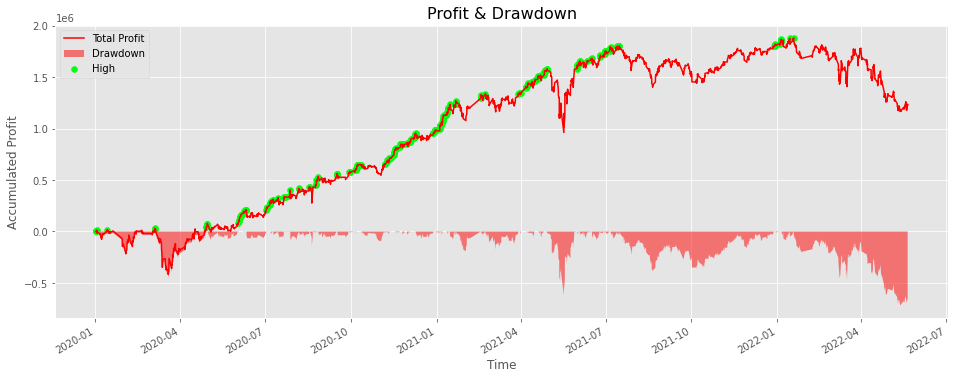

In [ ]:
fig, ax = plt.subplots(figsize = (16,6))

high_index = nequity[nequity['profitfee'].cummax() == nequity['profitfee']].index
nequity['profitfee'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(nequity['drawdown'].index, nequity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, nequity['profitfee'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);


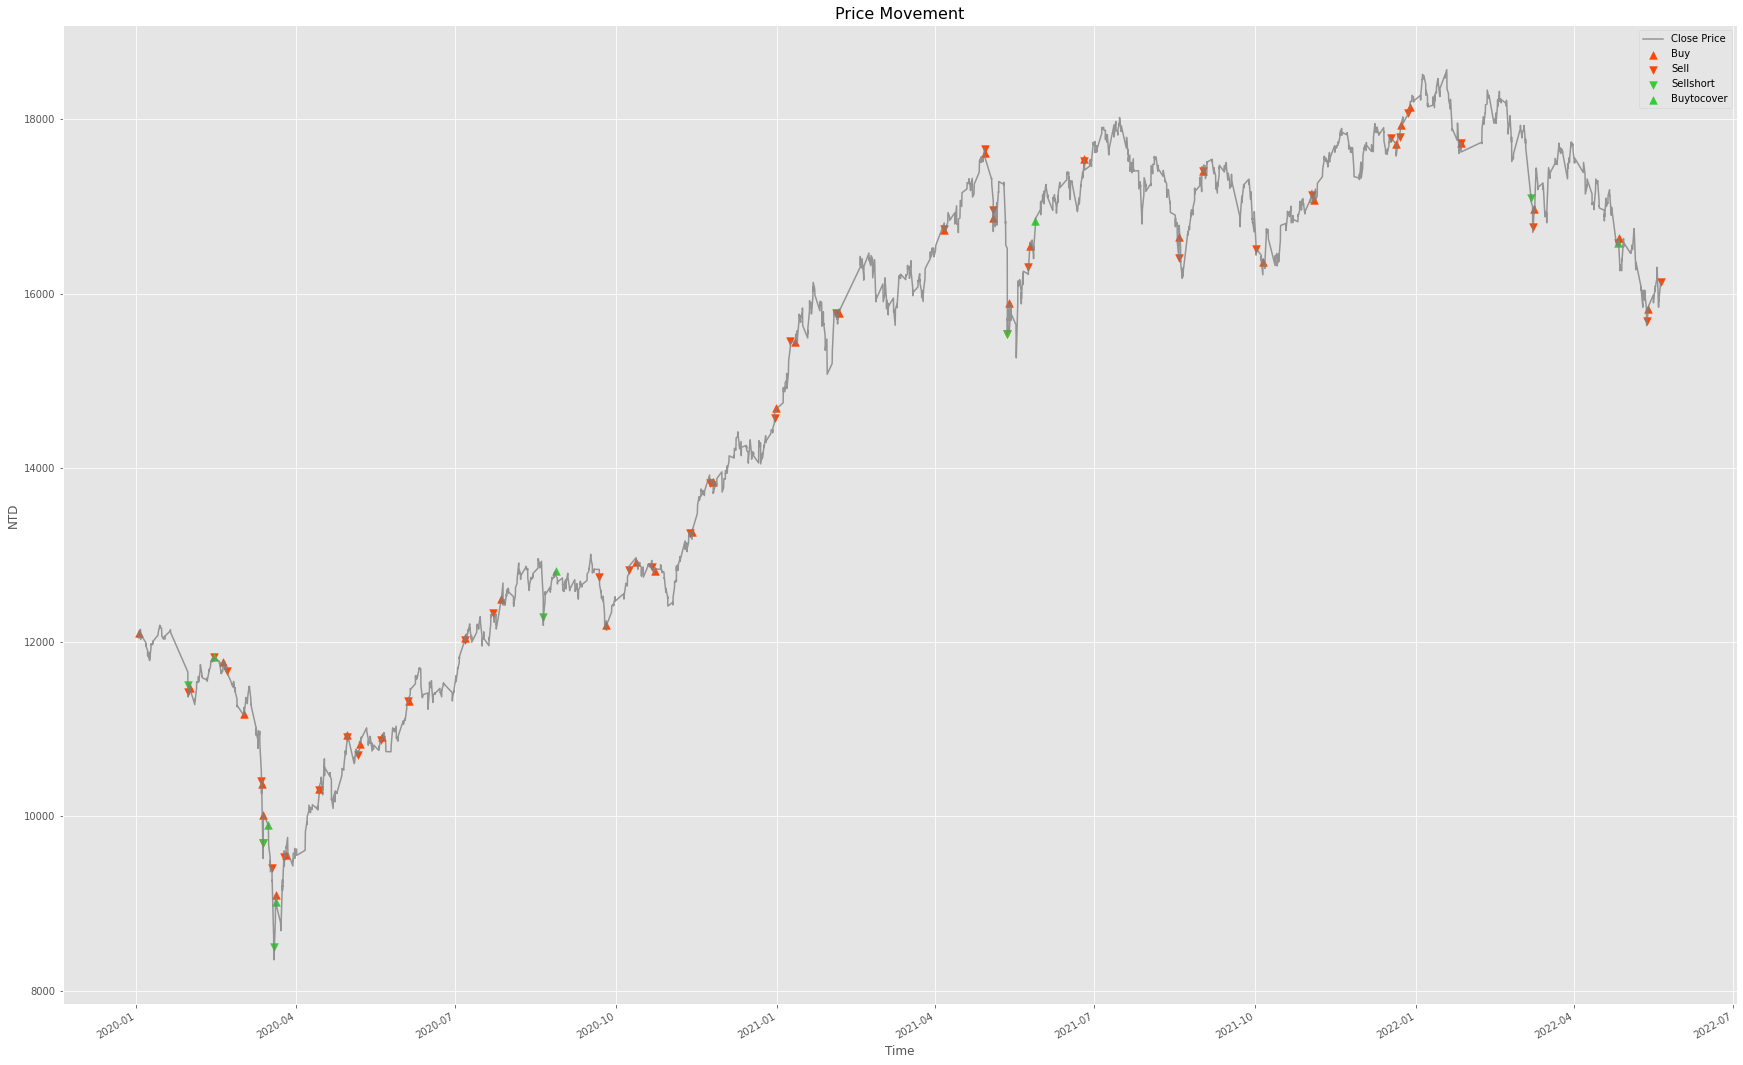

In [ ]:
fig, ax = plt.subplots(figsize = (30,20))

testData['close'].plot(label = 'Close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(testData['close'].iloc[buy].index, testData['close'].iloc[buy],c = 'orangered', label = 'Buy', marker='^', s=60)
plt.scatter(testData['close'].iloc[sell].index, testData['close'].iloc[sell],c = 'orangered', label = 'Sell', marker='v', s=60)
plt.scatter(testData['close'].iloc[bbuy].index, testData['close'].iloc[bbuy],c = 'limegreen', label = 'Sellshort', marker='v', s=60)
plt.scatter(testData['close'].iloc[ssell].index, testData['close'].iloc[ssell],c = 'limegreen', label = 'Buytocover', marker='^', s=60)

plt.legend()
plt.ylabel('NTD')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16);

In [ ]:
nprofit_fee_list_realized = vprofit_fee_list_realized +profit_fee_list_realized 

In [ ]:
profit = nequity['profitfee'].iloc[-1]
ret = nequity['equity'][-1]/nequity['equity'][0] - 1
mdd = abs(nequity['drawdown_percent'].min())
calmarRatio = ret / mdd
tradeTimes = len(buy)+len(sellshort)
winRate = len([i for i in nprofit_fee_list_realized if i > 0]) / len(nprofit_fee_list_realized)
profitFactor = sum([i for i in nprofit_fee_list_realized if i > 0]) / abs(sum([i for i in nprofit_fee_list_realized if i < 0]))
winLossRatio = np.mean([i for i in nprofit_fee_list_realized if i > 0]) / abs(np.mean([i for i in nprofit_fee_list_realized if i < 0]))

print(f'profit: ${np.round(profit,2)}')
print(f'return: {np.round(ret,4)*100}%')
print(f'mdd: {np.round(mdd,4)*100}%')
print(f'calmarRatio: {np.round(calmarRatio,2)}')
print(f'tradeTimes: {tradeTimes}')
print(f'winRate: {np.round(winRate,4)*100}%')
print(f'profitFactor: {np.round(profitFactor,2)}')
print(f'winLossRatio: {np.round(winLossRatio,2)}')

profit: $1233800.0
return: 123.38%
mdd: 43.4%
calmarRatio: 2.84
tradeTimes: 40
winRate: 65.22%
profitFactor: 1.6
winLossRatio: 0.85


In [ ]:
#一年20筆
#緩跌
#波動度要分上漲跟下

#停損跟廷力可以布一樣
#最佳化都用for
#波動度可以用ma的斜率
#std用%數